In [1]:
import sys
from pathlib import Path
PROJECT_ROOT = Path().cwd().resolve().parents[1]
sys.path.insert(0, str(PROJECT_ROOT))

print("Added:", PROJECT_ROOT)

print("CWD:", Path.cwd())
print("PROJECT_ROOT:", PROJECT_ROOT)
print("sys.path contains project root?:", str(PROJECT_ROOT) in sys.path)

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.optim import AdamW
from tqdm import tqdm
from src.dataset import HANDataset, build_vocab, create_balanced_dataloader, split_by_pid

from models.attention_rnn.attention_model import AttentionRNN
import yaml

# Load config
CONFIG_PATH = Path("config.yaml")

with open(CONFIG_PATH, "r") as f:
    config = yaml.safe_load(f)

Added: /Users/sun/Desktop/OMSCS/2025_Fall/Deep Learning/Projects/DeepPHQ
CWD: /Users/sun/Desktop/OMSCS/2025_Fall/Deep Learning/Projects/DeepPHQ/models/attention_rnn
PROJECT_ROOT: /Users/sun/Desktop/OMSCS/2025_Fall/Deep Learning/Projects/DeepPHQ
sys.path contains project root?: True


[nltk_data] Downloading package punkt to /Users/sun/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
data_cfg = config["data"]
root = Path(data_cfg["data_root"])

word_df = pd.read_csv(root / data_cfg["word_csv"])
sentence_df = pd.read_csv(root / data_cfg["sentence_csv"])
dialogue_df = pd.read_csv(root / data_cfg["dialogue_csv"])

In [3]:
# PID | Text (40–60 words) | PHQ_Score
print(word_df.head()) 
# PID | Text (1–2 sentences) | PHQ_Score
print(sentence_df.head())
# PID | Text | PHQ_Score
print(dialogue_df.head())

# Current HAN (Document → Sentences → Words)
# dialogue_df (Text) -> sentence_df (sentences) -> word tokenization

   PID                                               Text  PHQ_Score
0  300  me alright by field the weeks sun probably wha...          2
1  300  always don't alright uh just diploma yes prett...          2
2  300  it parents easy given i i'm uh diploma you say...          2
3  300  the you it something have easy real books i uh...          2
4  300  got on go parents i no i no business um grandp...          2
   PID                                               Text  PHQ_Score
0  300  two weeks ago once a year no do whatever i wan...          2
1  300  um my parents are from here um bye bye i like ...          2
2  300  [laughter] it's alright yeah i'm sure i could'...          2
3  300  high school i would have been probably out in ...          2
4  300  um in the career field um uh it's pretty easy ...          2
   PID                                               Text  PHQ_Score
0  300  i like the opportunities um yes um it took a m...          2
1  300  grandparents parents um ye

In [4]:
import nltk
nltk.download("punkt")
nltk.download('punkt_tab')

# 1. Building comprehensive vocab
all_texts = (
    word_df["Text"].tolist() + 
    sentence_df["Text"].tolist() + 
    dialogue_df["Text"].tolist()
)

vocab = build_vocab(all_texts, min_freq=config["vocab"]["min_freq"])

# 2-1. nltk (converting to hierarchical documents)
    # Working as a main source of data
train_df, val_df, test_df = split_by_pid(word_df)

train_dataset = HANDataset(train_df, vocab)
val_dataset   = HANDataset(val_df, vocab)
test_dataset  = HANDataset(test_df, vocab)

# 2-2. Index mapping (for each batch)
unique_scores = sorted(word_df["PHQ_Score"].unique())
score2idx = {score: idx for idx, score in enumerate(unique_scores)}
idx2score = {idx: score for score, idx in score2idx.items()}    

word_df["label_idx"] = word_df["PHQ_Score"].map(score2idx)
# 3. dataloaders
train_loader = create_balanced_dataloader(
    train_dataset,
    batch_size=config["dataloader"]["batch_size"]
)

val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 4. verify shapes
batch = next(iter(train_loader))
print(batch["input_ids"].shape)
print(batch["label"].shape)
print(batch["pid"].shape)

[nltk_data] Downloading package punkt to /Users/sun/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /Users/sun/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


Vocab size = 6265
torch.Size([16, 10, 30])
torch.Size([16])
torch.Size([16])


In [5]:
# ---- Load model config ----
model_cfg = config["model"]

# ---- Auto-select device ----
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

print("Using device:", device)

Using device: mps


In [6]:
NUM_CLASSES = word_df["PHQ_Score"].nunique()
NUM_CLASSES

23

In [7]:
# Model initialization
model = AttentionRNN(
    vocab_size=len(vocab),
    embed_dim=128,
    hidden_dim=64,
    num_classes=NUM_CLASSES,
    pad_idx=0,
    max_words=50,
    max_sentences=10
).to(device)

In [8]:
train_cfg = config["training"]

optimizer = AdamW(
    model.parameters(),
    lr=float(train_cfg["learning_rate"]),
    weight_decay=float(train_cfg["weight_decay"])
)

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

In [9]:
save_path="best_han.pt"
best_val_loss = float("inf")
num_epochs = train_cfg["num_epochs"]

avg_training_loss_list = []
avg_validation_loss_list = []

for epoch in range(num_epochs):

    # =========================================================
    #   TRAINING
    # =========================================================
    model.train()
    train_losses = []

    progress = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")

    for batch in progress:
        optimizer.zero_grad()

        docs = batch["input_ids"].to(device)          # [B, S, W]
        labels = batch["label"].to(device)      # [B]

        outputs = model(docs).squeeze(1)        # [B]

        loss = criterion(outputs, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), train_cfg['gradient_clip'])
        optimizer.step()

        train_losses.append(loss.item())
        progress.set_postfix({"loss": loss.item()})

    avg_train_loss = np.mean(train_losses)
    avg_training_loss_list.append(avg_train_loss)

    # =========================================================
    #   VALIDATION
    # =========================================================
    model.eval()
    val_losses = []

    with torch.no_grad():
        for batch in val_loader:
            docs = batch["input_ids"].to(device)
            labels = batch["label"].to(device)

            outputs = model(docs).squeeze(1)
            loss = criterion(outputs, labels)
            
            val_losses.append(loss.item())

    avg_val_loss = np.mean(val_losses)
    avg_validation_loss_list.append(avg_val_loss)

    print(f"Epoch {epoch+1}: Train={avg_train_loss:.4f}  Val={avg_val_loss:.4f}")

    # =========================================================
    #   SAVE BEST MODEL
    # =========================================================
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), save_path)
        print(f"Saved best model → {save_path}")

print("\nTraining complete!")
print(f"Best validation loss: {best_val_loss:.4f}")

Epoch 1/16: 100%|██████████| 94/94 [00:08<00:00, 10.90it/s, loss=3.18]


Epoch 1: Train=3.1340  Val=3.1578
Saved best model → best_han.pt


Epoch 2/16: 100%|██████████| 94/94 [00:05<00:00, 17.27it/s, loss=3.14]


Epoch 2: Train=3.1332  Val=3.1567
Saved best model → best_han.pt


Epoch 3/16: 100%|██████████| 94/94 [00:05<00:00, 16.74it/s, loss=3.13]


Epoch 3: Train=3.1282  Val=3.1559
Saved best model → best_han.pt


Epoch 4/16: 100%|██████████| 94/94 [00:05<00:00, 16.78it/s, loss=3.15]


Epoch 4: Train=3.1303  Val=3.1575


Epoch 5/16: 100%|██████████| 94/94 [00:05<00:00, 17.03it/s, loss=3.14]


Epoch 5: Train=3.1290  Val=3.1568


Epoch 6/16: 100%|██████████| 94/94 [00:05<00:00, 16.93it/s, loss=3.12]


Epoch 6: Train=3.1263  Val=3.1567


Epoch 7/16: 100%|██████████| 94/94 [00:05<00:00, 16.41it/s, loss=3.14]


Epoch 7: Train=3.1211  Val=3.1594


Epoch 8/16: 100%|██████████| 94/94 [00:05<00:00, 16.28it/s, loss=3.1] 


Epoch 8: Train=3.1238  Val=3.1597


Epoch 9/16: 100%|██████████| 94/94 [00:05<00:00, 17.55it/s, loss=3.11]


Epoch 9: Train=3.1257  Val=3.1624


Epoch 10/16: 100%|██████████| 94/94 [00:05<00:00, 17.29it/s, loss=3.1] 


Epoch 10: Train=3.1206  Val=3.1637


Epoch 11/16: 100%|██████████| 94/94 [00:05<00:00, 17.50it/s, loss=3.12]


Epoch 11: Train=3.1193  Val=3.1640


Epoch 12/16: 100%|██████████| 94/94 [00:05<00:00, 17.48it/s, loss=3.09]


Epoch 12: Train=3.1199  Val=3.1635


Epoch 13/16: 100%|██████████| 94/94 [00:05<00:00, 17.30it/s, loss=3.11]


Epoch 13: Train=3.1188  Val=3.1653


Epoch 14/16: 100%|██████████| 94/94 [00:05<00:00, 17.41it/s, loss=3.12]


Epoch 14: Train=3.1161  Val=3.1660


Epoch 15/16: 100%|██████████| 94/94 [00:05<00:00, 16.34it/s, loss=3.1] 


Epoch 15: Train=3.1159  Val=3.1680


Epoch 16/16: 100%|██████████| 94/94 [00:05<00:00, 16.51it/s, loss=3.1] 


Epoch 16: Train=3.1153  Val=3.1699

Training complete!
Best validation loss: 3.1559


In [10]:
# Future exploration:
# 1. switching from GRU to BiLSTM 
    # self.gru = nn.LSTM(... bidirectional=True)
# 2. Utilizing sentence_df
    # sentence_df
# 3. Adding regularization (e.g. dropout)

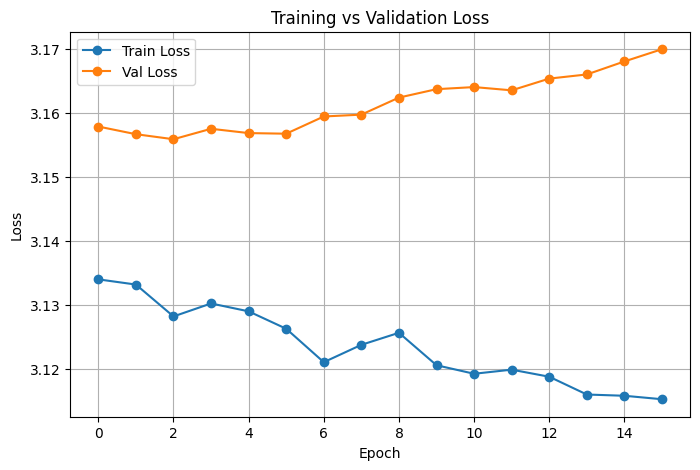

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(avg_training_loss_list, label="Train Loss", marker='o')
plt.plot(avg_validation_loss_list, label="Val Loss", marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()